# ML midterm project
## Anna Tigranyan

------------------------

# Task

**Part 1.**(1) Generate a dataset with the given features:<br>
Random variable  - V1 (uniformal distribution from 0,100)<br>
Random variable  - V2 (uniformal distribution from 100000,1000000)<br>
Create an Y target given the function<br>
Y = V0 + W1*V1 + W2*V2 + W3*sin(2𝜋V1) + W4*cos(2𝜋V2)<br>
Use a sigmoid function with a 50% threshold to generate the {0,1} labels. Split the data into train/test and hold out. Provide the Y & V1,V2 for the next task.<br>
<br>
**Part 2.**(2) Create an agent which will receive the train/test data, do required preprocessing and train a logistic classification model. Logistic regression should be written from scratch.<br>
<br>

**Part 3.**(2) Compare the model results with optimized versions of Decision Tree, Adaboost, Random Forest, SVM, Logistic <br>regression from Sklearn.


------------

## Libraries

In [199]:
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

________________________

# Part 1.(1) Generate a dataset with the given features:
- Random variable - **V1** (uniformal distribution from 0,100)
- Random variable - **V2** (uniformal distribution from 100000,1000000)
<br>

- Create an Y target given the function<br>
  **Y = V0 + W1V1 + W2V2 + W3sin(2𝜋V1) + W4cos(2𝜋V2)**<br>
  Use a **sigmoid** function with a **50% threshold** to generate the **{0,1} labels**. Split the data into **train/test** and hold out. Provide the **Y** & **V1**,**V2** for the next task.

Let's start to generate our variables: **V0 ,V1 ,V2**.<br>
We are going to generate 10000 points.

In [41]:
V0 = -105
V1 = np.random.uniform(0,100,10000)
V2 = np.random.uniform(100000,1000000,10000)

Now let's generate weights.

In [146]:
W1 = 1.52
W2 = 0.00005
W3 = 0.0002
W4 = 0.004

Since we already have our generated variables(VO,V1,V2) and we weights we can construct y from the given function:

In [160]:
Y = np.random.normal(V0 + W1*V1 + W2*V2 + W3*np.sin(2*np.pi*V1) + W4*np.cos(2*np.pi*V2),5)

Useing a **sigmoid function** with a **50% threshold** to generate the {0,1} labels.

In [148]:
# sigmoid function
sig = 1 / (1 + np.exp(-Y))

Checking the balance(number of 0s and 1s in our y)

In [149]:
(sig<0.5).sum()/100

50.8

From above we can see that we have approximately 50% 0s and 50% 1s in our y

Generating the **{0,1}** labels

In [150]:
y = [1 if i > 0.5 else 0 for i in Y ]

Now as we have our variables and our target variable y , we can construct a data frame containing them.

In [151]:
df = pd.DataFrame()

df['V1'] = V1.tolist()
df['V2'] = V2.tolist()
df['y'] = np.array(y).tolist()

In [152]:
df.head()

,V1,V2,y
0,58.593593,359394.715529,0
1,22.643027,646218.177431,0
2,68.229488,836887.398324,1
3,43.800315,603179.222229,0
4,30.761741,231221.536950,0


As a result we have data frame **df** containing:<br>
- V1
- V2
- y (target)

----------------

Let's do **train test split**.(train size 80%)

In [153]:
# Shuffle our dataset 
shuffle_df = df.sample(frac=1,random_state=101)

# Define a size for our train set 
train_size = int(0.8 * len(df))

# Train test split
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:]

# X_train, y_train, X_test, y_test
X_train = train_set[['V1','V2']]
X_test = test_set[['V1','V2']]
y_train = train_set['y']
y_test = test_set['y']

Let's check number of 0s and 1s in train and test datas:

In [163]:
y_train.value_counts()

0    4091
1    3909
Name: y, dtype: int64

In [164]:
y_test.value_counts()

0    1027
1     973
Name: y, dtype: int64

**Balance is normal** for train and test.

------------------

# Part 2.(2) Create an agent which will receive the train/test data, do required preprocessing and train a logistic classification model. Logistic regression should be written from scratch.

Lets's create **LogReg_FromScratch** class ( Logistic Regression model from scretch).

In [157]:
class LogReg_FromScratch:

    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            # approximate y with linear combination of weights and x, plus bias
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function
            y_predicted = self._sigmoid(linear_model)

            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))



-----------------

Because our **V1** and **V2** are in different ranges we need to do **scaling** before model construction.

In [168]:
scaler_sd = StandardScaler()

# Get scaling parameters with the X_train sample exclusively, using the Scaler.fit() function
scaler_sd.fit(X_train)

# Scale data using Scaler.transform()
X_train_scaled = scaler_sd.transform(X_train)
X_test_scaled = scaler_sd.transform(X_test)

--------------------------

In [169]:
model_log = LogReg_FromScratch()
model_log.fit(X_train_scaled, y_train)

In [170]:
print(classification_report(y_test, model_log.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1027
           1       0.96      0.97      0.97       973

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [173]:
confusion_matrix = pd.crosstab(y_test, model_log.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0    1
Actual             
0          991   36
1           28  945


From above we can see that LogReg_FromScratch model accuracy is 97% which means that our model predicts correctly (whether the y is 1  or 0 ) in 97% of cases.<br>
Recall ( TP/(TP+FN) - What proportion of actual positives was identified correctly ) for:
- 1s is 97% (The model predicts 96% of 1s correctly)
- 0s is 96% (The model predicts 97% of 0s correctly)
<br>

Precision ( TP/(TP+FP) - What proportion of positive identifications was actually correct ) for:
- 1s is 97%
- 0s is 96%

---------------------

# Part 3.(2) Compare the model results with optimized versions of Decision Tree, Adaboost, Random Forest, SVM, Logistic regression from Sklearn.

## Decision Tree

In [174]:
# model
dt = DecisionTreeClassifier()

# parameters for tuning
criterion = ['gini', 'entropy']
max_depth = [2,3,4,5,6,8,10,12,14,18,20]

# parameters dictionary
param_grid = {'criterion' : criterion , 'max_depth' : max_depth}

In [175]:
# grid search
grid = GridSearchCV(dt,param_grid)

#fitting
grid.fit(X_train_scaled,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 8, 10, 12, 14, 18, 20]})

In [176]:
# getting best parametrs for our Decision Tree model
g = grid.best_estimator_.get_params()
params = {'max_depth':g['max_depth'],'criterion':g['criterion']}
params

{'max_depth': 5, 'criterion': 'gini'}

In [177]:
# Decision Tree model with best parameters
model = DecisionTreeClassifier(max_depth=params['max_depth'],criterion=params['criterion'])

model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5)

In [178]:
# printing classification report
print(classification_report(y_test, model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1027
           1       0.98      0.96      0.97       973

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



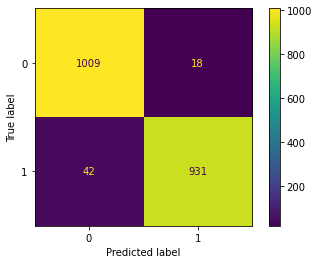

In [179]:
# printing confuzion matrix
plot_confusion_matrix(model,X_test_scaled,y_test);

Accuracy is the same as for LogReg_FromScratch model but from confuzion matrix we can see that Decision tree model 1's predicts worse than the LogReg_FromScratch model.

-------------------------------

## Logistic regression

In [184]:
# model
log = LogisticRegression()

# parameters for tuning
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2','l1','elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

#parameters dictionory
grid = dict(solver=solvers,penalty=penalty,C=c_values)

# grid search 
grid_search_log = GridSearchCV(estimator=log, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)

# fitting (we are going to use scaled x train)
grid_search_log.fit(X_train_scaled,y_train)

# getting best parametrs
g = grid_search_log.best_estimator_.get_params()

params_log = {'solver':g['solver'],'C':g['C'],'penalty':g['penalty']}
params_log

{'solver': 'liblinear', 'C': 10, 'penalty': 'l1'}

In [185]:
# Logistic regression model with best parameters

log_model = LogisticRegression(C= params_log['C'], penalty=params_log['penalty'], solver=params_log['solver'])
log_model.fit(X_train_scaled, y_train)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [186]:
# Printing classification report

print(classification_report(y_test, log_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1027
           1       0.98      0.98      0.98       973

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



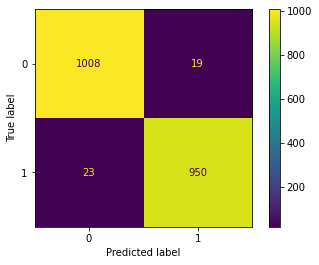

In [187]:
# Printing confuzion matrix

plot_confusion_matrix(log_model,X_test_scaled,y_test)

From above we can see that Logistic Regression model with hyperparameters tuning is better(**98% accuracy**) than previous 2 models.(Decision tree and LogReg_FromScretch)

-----------------------------------

## SVM

In [188]:
SVM = svm.SVC()

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid_svm = GridSearchCV(SVM,param_grid,refit=True)
grid_svm.fit(X_train_scaled,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [189]:
# getting best parametrs
g = grid_svm.best_estimator_.get_params()

params_svm = {'gamma':g['gamma'],'C':g['C'],'kernel':g['kernel']}
params_svm

{'gamma': 0.01, 'C': 1, 'kernel': 'rbf'}

In [190]:
# SVM model with best parameters

svm_model = svm.SVC(C= params_svm['C'], gamma=params_svm['gamma'], kernel=params_svm['kernel'])
svm_model.fit(X_train_scaled, y_train)

SVC(C=1, gamma=0.01)

In [191]:
# Printing classification report
print(classification_report(y_test, svm_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1027
           1       0.98      0.98      0.98       973

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



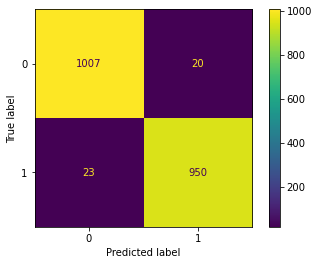

In [192]:
# printing confuzion matrix
plot_confusion_matrix(svm_model,X_test_scaled,y_test);

From above we can see that SVM model performed like Logistic Regression model.Accuracy is **98%**.

------------------------

## Random Forest

In [193]:
rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [100,200,500,1000,2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [50,60,70,100,150,200,300]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
# grid search
grid_rf = GridSearchCV(rf, param_grid, cv = 3, n_jobs = -1)

#fitting
grid_rf.fit(X_train_scaled,y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [50, 60, 70, 100, 150, 200, 300],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200, 500, 1000, 2000]})

In [194]:
g = grid_rf.best_estimator_.get_params()

params_rf = {'n_estimators':g['n_estimators'],'max_features':g['max_features'],'max_depth':g['max_depth']}
params_rf

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': 150}

In [195]:
# Random Foredt model with best parameters
rf_model = RandomForestClassifier(n_estimators=params_rf['n_estimators'],max_features=params_rf['max_features'],
                               max_depth=params_rf['max_depth'])

rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=150)

In [196]:
# Printing classification report
print(classification_report(y_test, rf_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1027
           1       0.98      0.97      0.97       973

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



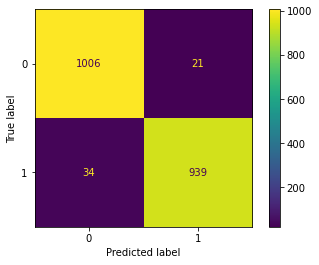

In [197]:
# printing confuzion matrix
plot_confusion_matrix(rf_model,X_test_scaled,y_test);

Random forest model accuracy is 97%.

_______________________________

## Adaboost

In [205]:
model_ada = AdaBoostClassifier()

params = dict()
params['n_estimators'] = [50, 100, 500,1000]
params['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
grid_ada = GridSearchCV(estimator=model_ada, param_grid=params, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_ada.fit(X_train_scaled,y_train) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 500, 1000]},
             scoring='accuracy')

In [206]:
g = grid_ada.best_estimator_.get_params()

params_ada = {'n_estimators':g['n_estimators'],'learning_rate':g['learning_rate']}
params_ada

{'n_estimators': 500, 'learning_rate': 0.1}

In [207]:
# Adaboost model with best parameters
ada_model = AdaBoostClassifier(n_estimators=params_ada['n_estimators'],learning_rate=params_ada['learning_rate'])

ada_model.fit(X_train_scaled, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=500)

In [208]:
# Printing classification report
print(classification_report(y_test, ada_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1027
           1       0.98      0.98      0.98       973

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



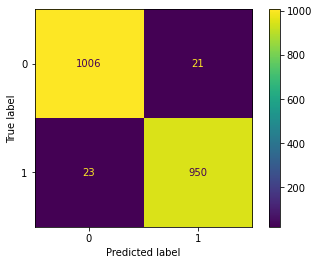

In [209]:
# printing confuzion matrix
plot_confusion_matrix(ada_model,X_test_scaled,y_test);

From above we can see that Adaboost model accuracy is 98% and its performance like Logistic regression and SVM models performances.

----------------------

We have following models and accuracies:<br>
-  LogReg_FromScratch - accuracy: 97%
- Logistic regression - accuracy: 98%
- SVM - accutacy: 98%
- Decision Tree - accuracy: 97%
- Random Forest - accuracy: 97%
- Adaboost - accuracy: 98%
<br>

The best model is **Logistic  Regression** model (although SVM և Adaboost are slightly behind it).